In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from prophet import Prophet

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# XGBoost + Prophet
Prophet is performing better than XGB but seems to miss some weather patterns and escape the CI bounds during high season. 

Plan: Use simple prophet model (no covariates) and train XGboost on Prophet errors. 
p(x) = y_hat <- Prophet model
g(y_hat, ) = y_hat_final <- 

In [246]:
df = pd.read_csv('./data/daily.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [247]:
def create_date_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    return df

def clean_nas(df):
    df = df.copy()
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    return df

In [248]:
df = create_date_features(df)
df = clean_nas(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12584 entries, 1990-01-01 to 2024-06-14
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TAVG_flag       12584 non-null  object 
 1   TAVG_origFlag   12584 non-null  object 
 2   TAVG_origValue  12584 non-null  float64
 3   TAVG_value      12584 non-null  float64
 4   WTEQ_average    12584 non-null  float64
 5   WTEQ_flag       12584 non-null  object 
 6   WTEQ_origFlag   12584 non-null  object 
 7   WTEQ_origValue  12584 non-null  float64
 8   WTEQ_value      12584 non-null  float64
 9   agency_cd       12584 non-null  object 
 10  site_no         12584 non-null  int64  
 11  CFS             12584 non-null  int64  
 12  status          12584 non-null  object 
 13  year            12584 non-null  int32  
 14  quarter         12584 non-null  int32  
 15  month           12584 non-null  int32  
 16  week            12584 non-null  UInt32 
 17  dayofyear     

# Processing for Prophet fit

In [249]:
df['ds'] = df.index
df['y'] = np.log(df['CFS'])
df.ffill(inplace=True)

In [250]:
cutoff = pd.to_datetime("2005-01-01") # Only train Prophet on first ~40% of data
pr_train = df.loc[df["ds"] < cutoff]
xg_train = df.loc[df["ds"] >= cutoff] # Clean (no data leakage on prophet training)
pr_train.shape, xg_train.shape

((5479, 20), (7105, 20))

# Train test split for XGb CV

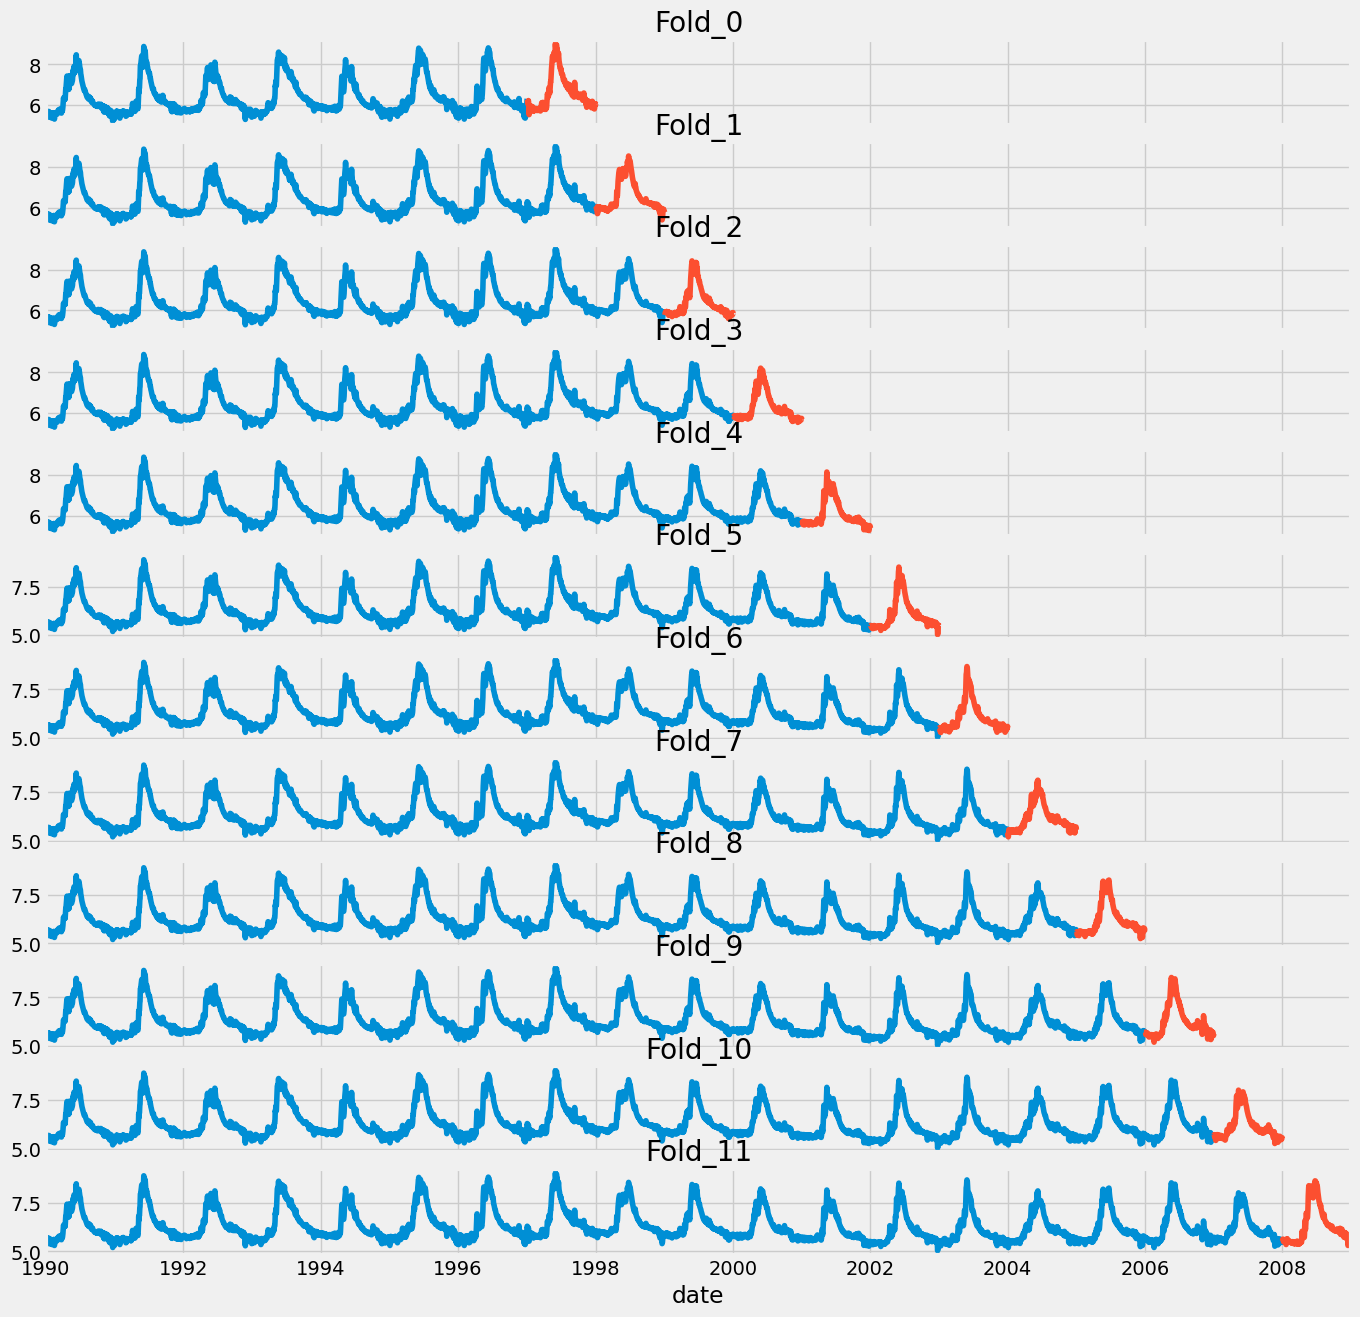

In [251]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()
cutoff = pd.to_datetime('2024-01-01')
df_h = xg_train.loc[xg_train.index > cutoff]
df_tss = xg_train.loc[xg_train.index <= cutoff]
fig, axs = plt.subplots(splits, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df_tss):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train["y"].plot(ax=axs[fold], label="TRAIN", title=f"Fold_{fold}")
    test["y"].plot(ax=axs[fold], label="TEST")
    fold += 1
plt.show()

## Make Extra features 
(For XGboost, not prophet)

In [252]:
def add_cfs_lags(df):
    target_map = df['CFS'].to_dict()
    df['CFS_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['CFS_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['CFS_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['CFS_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_temp_lags(df):
    target_map = df['TAVG_origValue'].to_dict()
    df['TAVG_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['TAVG_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['TAVG_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['TAVG_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_first_difference(df, column_name='WTEQ_origValue'):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame")

    diff_column_name = f'{column_name}_diff'
    df[diff_column_name] = df[column_name].diff()

    return df

In [253]:
xg_train = add_cfs_lags(xg_train)
pr_train = add_cfs_lags(pr_train)
xg_train = add_temp_lags(xg_train)
pr_train = add_temp_lags(pr_train)
xg_train = add_first_difference(xg_train)
pr_train = add_first_difference(pr_train)

In [254]:
xg_train.head()

,TAVG_flag,TAVG_origFlag,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_flag,WTEQ_origFlag,WTEQ_origValue,WTEQ_value,agency_cd,...,y,CFS_lag1,CFS_lag2,CFS_lag3,CFS_lag365,TAVG_lag1,TAVG_lag2,TAVG_lag3,TAVG_lag365,WTEQ_origValue_diff
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,V,V,14.2,14.2,9.9,V,V,9.1,9.1,USGS,...,5.560682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02,V,V,12.6,12.6,10.0,V,V,9.1,9.1,USGS,...,5.575949,260.0,NaN,NaN,NaN,14.2,NaN,NaN,NaN,0.0
2005-01-03,V,V,17.6,17.6,10.1,V,V,9.1,9.1,USGS,...,5.568345,264.0,260.0,NaN,NaN,12.6,14.2,NaN,NaN,0.0
2005-01-04,V,V,3.9,3.9,10.2,E,V,9.0,9.1,USGS,...,5.594711,262.0,264.0,260.0,NaN,17.6,12.6,14.2,NaN,-0.1
2005-01-05,V,V,7.2,7.2,10.3,V,V,9.1,9.1,USGS,...,5.488938,269.0,262.0,264.0,NaN,3.9,17.6,12.6,NaN,0.1


# Fit both models

In [261]:
pm = Prophet(seasonality_mode="multiplicative", 
            growth='flat')
pm.fit(pr_train)

16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1] done processing


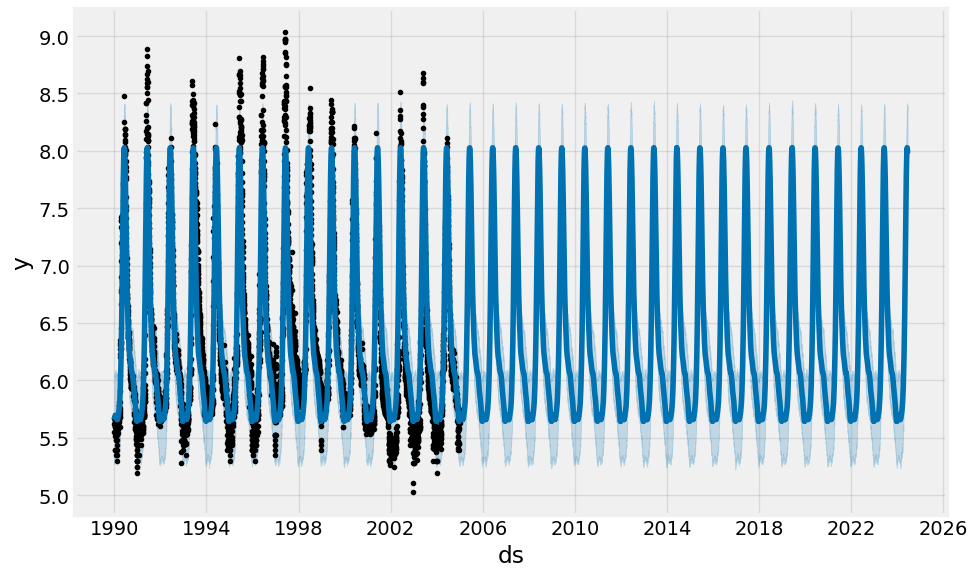

In [262]:
# Getting the 
periods_forward = len(df) - len(pr_train)
future = pm.make_future_dataframe(periods=periods_forward)
forecast = pm.predict(future)
pm.plot(forecast)
forecast = forecast[forecast["ds"] >= xg_train["ds"].iloc[0]]
backcast = pm.predict(pm.make_future_dataframe(periods=0))

<Axes: xlabel='date', ylabel='real_err'>

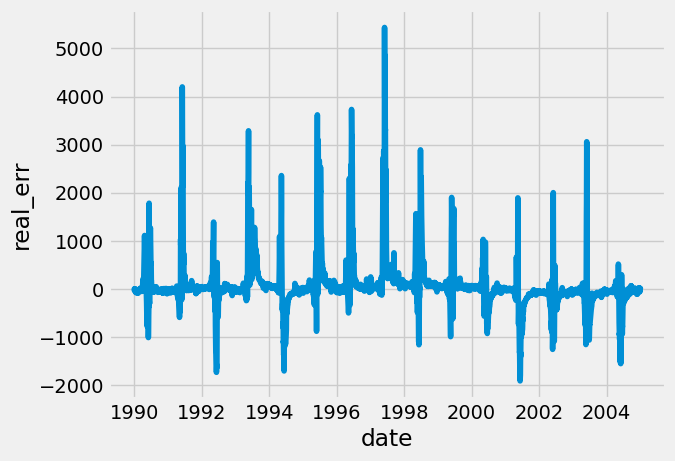

In [305]:
xg_train["yhat"] = forecast["yhat"].values
xg_train["real_err"] = np.int64(xg_train["CFS"] - np.exp(xg_train["yhat"]))
xg_train["p_err"] = np.float32(xg_train["y"] - xg_train["yhat"])
pr_train["yhat"] = backcast["yhat"].values
pr_train["real_err"] = np.int64(pr_train["CFS"] - np.exp(pr_train["yhat"]))
pr_train["p_err"] = np.float32(pr_train["y"] - pr_train["yhat"])
sns.lineplot(x="date", y="real_err", data=pr_train)

In [330]:
splits = 5
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
pr_train = pr_train.sort_index().dropna(subset=["p_err"])

fold = 0
preds = []
scores = []
mapes = []
for train_idx, val_idx in tss.split(pr_train):
    train = pr_train.iloc[train_idx]
    test = pr_train.iloc[val_idx]
    # f(yhat) = p_err
    # TARGET = 'p_err'
    TARGET = 'real_err'
    # FEATURES = ['yhat', 'TAVG_origValue', 'WTEQ_origValue',
    #             'CFS_lag1', 'CFS_lag2', 'WTEQ_origValue_diff',
    #             'week', 'dayofyear']
    FEATURES = ['yhat', 'dayofyear', 'TAVG_origValue']

    X_train = train[FEATURES].values.astype(np.float32)
    y_train = train[TARGET].astype(np.float32)

    X_test = test[FEATURES].values.astype(np.float32)
    y_test = test[TARGET].astype(np.float32)

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, early_stopping_rounds=30,
                          objective='reg:squarederror', max_depth=3, learning_rate=.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)
    mapes.append(mape)
    fold += 1
    print(f'#### Finished fold {fold} of {splits} ####')
print(f'RMSE Avg across folds {np.mean(scores):0.4f}')
print(f'MAPE Avg across foles {np.mean(mapes):0.4f}')

[0]	validation_0-rmse:495.50552	validation_1-rmse:432.77542


[100]	validation_0-rmse:457.79358	validation_1-rmse:400.95074
[162]	validation_0-rmse:449.08982	validation_1-rmse:402.29718
#### Finished fold 1 of 5 ####
[0]	validation_0-rmse:491.67196	validation_1-rmse:223.41432
[30]	validation_0-rmse:475.55475	validation_1-rmse:231.45085
#### Finished fold 2 of 5 ####
[0]	validation_0-rmse:479.70880	validation_1-rmse:552.91963
[100]	validation_0-rmse:446.66104	validation_1-rmse:549.18921
[112]	validation_0-rmse:444.86870	validation_1-rmse:551.76637
#### Finished fold 3 of 5 ####
[0]	validation_0-rmse:484.22130	validation_1-rmse:517.50883
[100]	validation_0-rmse:455.32470	validation_1-rmse:458.60514
[200]	validation_0-rmse:442.45119	validation_1-rmse:438.08369
[300]	validation_0-rmse:434.05799	validation_1-rmse:432.28175
[400]	validation_0-rmse:428.66183	validation_1-rmse:430.69335
[418]	validation_0-rmse:427.75578	validation_1-rmse:430.66717
#### Finished fold 4 of 5 ####
[0]	validation_0-rmse:486.03797	validation_1-rmse:298.50083
[59]	validation_0

In [331]:
print(f'RMSE Avg across folds {np.mean(scores):0.4f}')
print(f'MAPE Avg across foles {np.mean(mapes):0.4f}')
print(f'\n Scores: {scores}')
print(f'\n MAPES: {(mapes)}')

RMSE Avg across folds 379.1486
MAPE Avg across foles 784914958830796.7500

 Scores: [np.float64(399.07404544770884), np.float64(223.41432572129298), np.float64(546.2956502664102), np.float64(430.390810775509), np.float64(296.5680123302242)]

 MAPES: [1168476722954240.0, 39077164351488.0, 515063383326720.0, 1614128837820416.0, 587828685701120.0]


## Hyperparameter tuning:
(still pr_train subset)

In [336]:
splits = 8
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
pr_train = pr_train.sort_index()
# Also holdout this year
cutoff = pd.to_datetime('2023-01-01')
df_holdout = pr_train.loc[pr_train.index > cutoff]
pr_train = pr_train.loc[pr_train.index <= cutoff]


fold = 0
preds = []
scores = []
mapes = []
best_params = []

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'alpha': uniform(0, 1),
    'lambda': uniform(0, 1),
}

TARGET = 'real_err'
FEATURES = ['yhat', 'WTEQ_average', 'CFS_lag1', 'TAVG_origValue',
            'CFS_lag2', 'month', 'dayofyear']

for train_idx, val_idx in tss.split(pr_train):
    train = pr_train.iloc[train_idx]
    test = pr_train.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree')

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=100,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    preds.append(y_pred)

    # Calculate metrics
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)
    mapes.append(mape)
    best_params.append(random_search.best_params_)

    fold += 1
    print(f'#### Finished fold {fold} of {splits} ####')
    print(f'Best parameters: {random_search.best_params_}')
    print(f'RMSE: {score}')
    print(f'MAPE: {mape}')
    print('-------------------')

# Print overall results
print(f'Average RMSE: {np.mean(scores)}')
print(f'Average MAPE: {np.mean(mapes)}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
#### Finished fold 1 of 8 ####
Best parameters: {'alpha': np.float64(0.24848913981446574), 'colsample_bytree': np.float64(0.8975785170290708), 'gamma': np.float64(0.01676621736788969), 'lambda': np.float64(0.5698896848713165), 'learning_rate': np.float64(0.23873760572220715), 'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 905, 'subsample': np.float64(0.8145925405938379)}
RMSE: 96.61624212412477
MAPE: 3100988130983936.0
-------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits
#### Finished fold 2 of 8 ####
Best parameters: {'alpha': np.float64(0.16162871409461377), 'colsample_bytree': np.float64(0.9594216754108317), 'gamma': np.float64(0.30321452982979497), 'lambda': np.float64(0.009197051616629648), 'learning_rate': np.float64(0.04044146285980963), 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 960, 'subsample': np.float64(0.7135683898949863)}
RMSE: 100.72683123800728
MAPE: 24079484

/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### Finished fold 4 of 8 ####
Best parameters: {'alpha': np.float64(0.16162871409461377), 'colsample_bytree': np.float64(0.9594216754108317), 'gamma': np.float64(0.30321452982979497), 'lambda': np.float64(0.009197051616629648), 'learning_rate': np.float64(0.04044146285980963), 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 960, 'subsample': np.float64(0.7135683898949863)}
RMSE: 160.18615269624587
MAPE: 1076258741944320.0
-------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits
#### Finished fold 5 of 8 ####
Best parameters: {'alpha': np.float64(0.3456672833238632), 'colsample_bytree': np.float64(0.9587153639624048), 'gamma': np.float64(0.23698082013143618), 'lambda': np.float64(0.6675577385210272), 'learning_rate': np.float64(0.06169596136048895), 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 888, 'subsample': np.float64(0.6675740252288658)}
RMSE: 105.56994219621653
MAPE: 341227501256704.0
-------------------
Fitting 3 folds for each of 100 c

/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### Finished fold 6 of 8 ####
Best parameters: {'alpha': np.float64(0.16162871409461377), 'colsample_bytree': np.float64(0.9594216754108317), 'gamma': np.float64(0.30321452982979497), 'lambda': np.float64(0.009197051616629648), 'learning_rate': np.float64(0.04044146285980963), 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 960, 'subsample': np.float64(0.7135683898949863)}
RMSE: 130.4811783002629
MAPE: 1357250467725312.0
-------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### Finished fold 7 of 8 ####
Best parameters: {'alpha': np.float64(0.16162871409461377), 'colsample_bytree': np.float64(0.9594216754108317), 'gamma': np.float64(0.30321452982979497), 'lambda': np.float64(0.009197051616629648), 'learning_rate': np.float64(0.04044146285980963), 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 960, 'subsample': np.float64(0.7135683898949863)}
RMSE: 92.59110800314467
MAPE: 627184611885056.0
-------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits
#### Finished fold 8 of 8 ####
Best parameters: {'alpha': np.float64(0.16162871409461377), 'colsample_bytree': np.float64(0.9594216754108317), 'gamma': np.float64(0.30321452982979497), 'lambda': np.float64(0.009197051616629648), 'learning_rate': np.float64(0.04044146285980963), 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 960, 'subsample': np.float64(0.7135683898949863)}
RMSE: 219.24389779136385
MAPE: 1259660623478784.0
-------------------
Average RMSE: 129.1532929155706

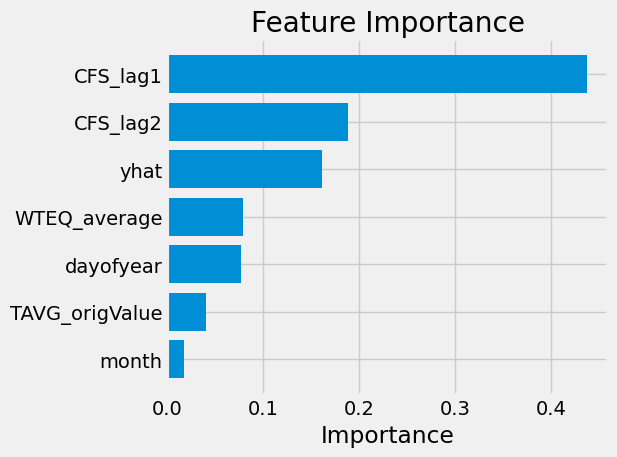

In [337]:
# FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
#             'CFS_lag1', 'CFS_lag2', 'CFS_lag365', 'TAVG_lag1', 'TAVG_lag2',
#             'TAVG_lag365', 'WTEQ_origValue_diff',
#             'quarter', 'month', 'week', 'dayofyear']
# Average RMSE: 0.05455613902274042 
# Average MAPE: 0.03724703573183385
importance = best_model.feature_importances_
sorted_idx = importance.argsort()
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [FEATURES[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

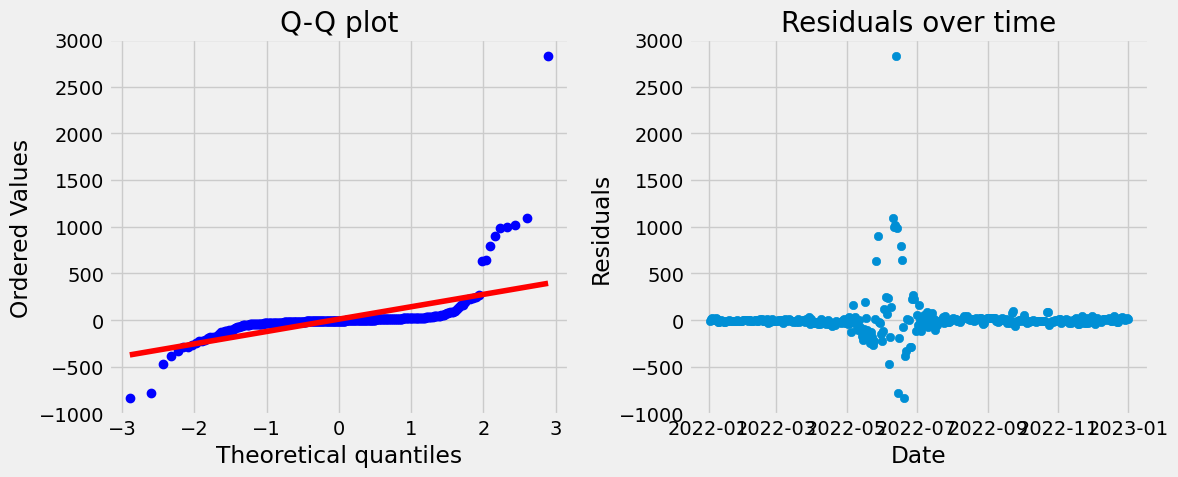

In [338]:
import scipy.stats as stats

residuals = y_test - y_pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q plot")

ax2.scatter(test.index, residuals)
ax2.set_title("Residuals over time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()

## Checkout forecast for 2024

In [346]:
df_and_future

,TAVG_flag,TAVG_origFlag,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_flag,WTEQ_origFlag,WTEQ_origValue,WTEQ_value,agency_cd,...,CFS_lag365,TAVG_lag1,TAVG_lag2,TAVG_lag3,TAVG_lag365,WTEQ_origValue_diff,yhat,p_err,real_err,is_future
2005-01-01,V,V,14.2,14.2,9.9,V,V,9.1,9.1,USGS,...,NaN,NaN,NaN,NaN,NaN,NaN,5.658714,-0.098032,-26.0,False
2005-01-02,V,V,12.6,12.6,10.0,V,V,9.1,9.1,USGS,...,NaN,14.2,NaN,NaN,NaN,0.0,5.663448,-0.087499,-24.0,False
2005-01-03,V,V,17.6,17.6,10.1,V,V,9.1,9.1,USGS,...,NaN,12.6,14.2,NaN,NaN,0.0,5.665119,-0.096775,-26.0,False
2005-01-04,V,V,3.9,3.9,10.2,E,V,9.0,9.1,USGS,...,NaN,17.6,12.6,14.2,NaN,-0.1,5.668645,-0.073934,-20.0,False
2005-01-05,V,V,7.2,7.2,10.3,V,V,9.1,9.1,USGS,...,NaN,3.9,17.6,12.6,NaN,0.1,5.673178,-0.184240,-48.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [345]:
best_params = random_search.best_params_
df = pd.concat([pr_train, xg_train])
full_model_pro = Prophet(seasonality_mode="multiplicative", growth='flat').fit(df)
full_model_xgb: xgb.XGBRegressor = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', **best_params).fit(df[FEATURES], df[TARGET])
future = pd.date_range("2024-01-02", "2024-06-14", freq="1d")
future_df = pd.DataFrame(index=future)
future_df['is_future'] = True
future_df['CFS'] = df_holdout['CFS']
for f in FEATURES:
    future_df[f] = df_holdout[f]

df['is_future'] = False
df_and_future = pd.concat([df, future_df])
pro_pred = full_model_pro.predict(df_and_future[*FEATURES, "ds"])
df_and_future['CFS_pred'] = pro_pred + full_model_xgb.predict(df_and_future[FEATURES])

17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing


KeyError: ('yhat', 'WTEQ_average', 'CFS_lag1', 'TAVG_origValue', 'CFS_lag2', 'month', 'dayofyear', 'ds')

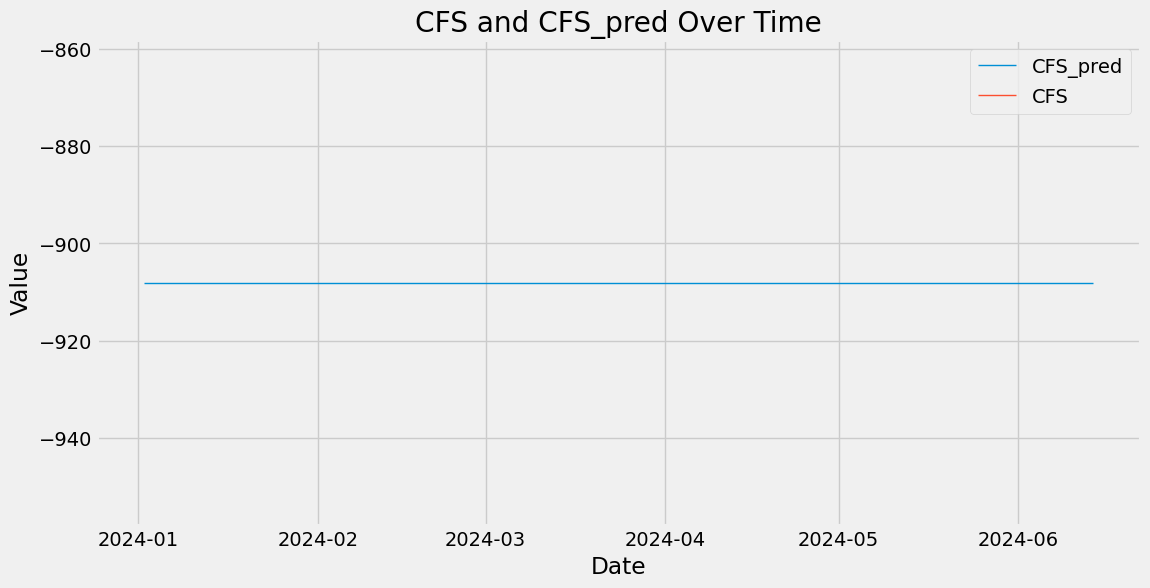

In [343]:
future_data = df_and_future.query('is_future')

plt.figure(figsize=(12, 6))
plt.plot(future_data.index, future_data['CFS_pred'], label='CFS_pred', lw=1)
plt.plot(future_data.index, future_data['CFS'], label='CFS', lw=1)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('CFS and CFS_pred Over Time')
plt.legend()
plt.savefig('xgb_preds_2024.jpg', format='jpg', dpi=200, bbox_inches='tight')
plt.show()

In [22]:
print(f"MAPE: {mean_absolute_percentage_error(future_data['CFS'], future_data['CFS_pred'])}")

MAPE: 0.06057944258319609
